In [30]:
#libraries
library(GO.db)
library(topGO)
# library(org.Hs.eg.db)
library(org.Sc.sgd.db)
library(GOSemSim)
library(gridExtra)


Attaching package: ‘gridExtra’

The following object is masked from ‘package:Biobase’:

    combine

The following object is masked from ‘package:BiocGenerics’:

    combine



In [18]:
file <- "yeast_uetz"

ont <- "BP"
p <- 0.1
init <- 1

db <- org.Sc.sgd.db
mapping <- "org.Sc.sgd.db"
ID <- "ENSEMBL"
# db <- org.Hs.eg.db
# mapping <- "org.Hs.eg.db"
# ID <- "ENTREZ"

##load all community gene lists
setwd(sprintf("/home/david/Documents/ghsom/%s_communities_%s_%s", file, p, init))

#background gene list
backgroundFilename <- "all_genes.txt"
allGenes <- scan(backgroundFilename, character())

#load communities from file
g <- list()
numCom <- 0
filename <- sprintf("community_%s.txt", numCom)
while (file.exists(filename)) {
    numCom <- numCom + 1
    g[[numCom]] <- scan(filename, character())
    filename <- sprintf("community_%s.txt", numCom)
}

#distances between neurons
shortest.path <- read.csv("shortest_path.csv", sep=",", header=FALSE)

In [19]:
numCom

[1] 51

In [26]:
names <- character()
for (i in 1:length(g)){
    names <- c(names, sprintf("Com %s", i))
}

In [4]:
##SEMATIC SIMILARITY
#construct gosemsim object

scGO <- godata(mapping, ont=ont, keytype=ID)
print("DONE")

[1] "preparing gene to GO mapping data..."
[1] "preparing IC data..."
[1] "DONE"


In [64]:
allGeneNames <- scan(character(), file="../yeast_uetz_communities_0.5_1/all_genes.txt")

g  <- sapply(g, function(i) allGeneNames[as.integer(i)])
allGenes <- allGeneNames[as.integer(allGenes)]

In [20]:
enrichedGOTerms <- function(genes, allGenes, cutoff, correction, ont, mapping, ID, algorithm){
    interestingGenes <- factor(as.integer(allGenes %in% genes))
    names(interestingGenes) <- allGenes
    
    GOdata <- new("topGOdata", description=sprintf("topGO object"),
              ontology = ont, allGenes = interestingGenes,
              annotationFun = annFUN.org, mapping = mapping, 
              ID = ID, nodeSize = 10)
    
    result <- runTest(GOdata, algorithm = algorithm, statistic = "fisher")
    if (correction){
        GOs <- score(result)[which(p.adjust(score(result), method="BH") <= cutoff)]
    } else {
        GOs <- score(result)[score(result) <= cutoff]
    }
    
    plot <- showSigOfNodes(GOdata, score(result), firstSigNodes = 10, useInfo ='all', swPlot = FALSE)
    
    return(list(GOdata, GOs, plot))
}

In [21]:
enrichedGOs  <- sapply(g, enrichedGOTerms, allGenes=allGenes, 
                      cutoff=0.05, correction=FALSE, ont=ont, mapping=mapping, ID=ID, algorithm="weight01")


Building most specific GOs .....
	( 571 GO terms found. )

Build GO DAG topology ..........
	( 1846 GO terms and 4079 relations. )

Annotating nodes ...............
	( 250 genes annotated to the GO terms. )

			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 95 nontrivial nodes
		 parameters: 
			 test statistic: fisher

	 Level 9:	1 nodes to be scored	(0 eliminated genes)

	 Level 8:	2 nodes to be scored	(0 eliminated genes)

	 Level 7:	3 nodes to be scored	(12 eliminated genes)

	 Level 6:	7 nodes to be scored	(21 eliminated genes)

	 Level 5:	21 nodes to be scored	(45 eliminated genes)

	 Level 4:	27 nodes to be scored	(139 eliminated genes)

	 Level 3:	22 nodes to be scored	(197 eliminated genes)

	 Level 2:	11 nodes to be scored	(216 eliminated genes)

	 Level 1:	1 nodes to be scored	(230 eliminated genes)

Building most specific GOs .....
	( 571 GO terms found. )

Build GO DAG topology ..........
	( 1846 GO terms and 4079 relations. )

Annotating nodes ...............
	(

In [10]:
lengths(enrichedGOs)

[1]  1 20  2  1  5  2  1  7  2  1  8  2  1 13  2  1  3  2

In [11]:
p.values <- enrichedGOs[2,]

In [22]:
mgeneSim(genes = g[[1]], semData = scGO, measure = "Wang", combine = "BMA")

  |======================================================================| 100%


,YER179W,YIL105C,YMR068W,YDR326C,YNL047C,YPL059W,YOR353C
YER179W,1.000,0.298,0.252,0.067,0.298,0.284,0.228
YIL105C,0.298,1.000,0.711,0.617,1.000,0.300,0.421
YMR068W,0.252,0.711,1.000,0.083,0.711,0.255,0.490
YDR326C,0.067,0.617,0.083,1.000,0.617,0.059,0.121
YNL047C,0.298,1.000,0.711,0.617,1.000,0.300,0.421
YPL059W,0.284,0.300,0.255,0.059,0.300,1.000,0.227
YOR353C,0.228,0.421,0.490,0.121,0.421,0.227,1.000


In [36]:
clusterSims <- sapply(g, function(i) 
    mean(mgeneSim(genes = i, semData = scGO, measure = "Wang", combine = "BMA", verbose = FALSE)))

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [38]:
mean(clusterSims)

[1] 0.5742647

In [23]:
mclusterSim <- mclusterSim(clusters = g, semData = scGO, measure = "Wang", combine = "BMA")

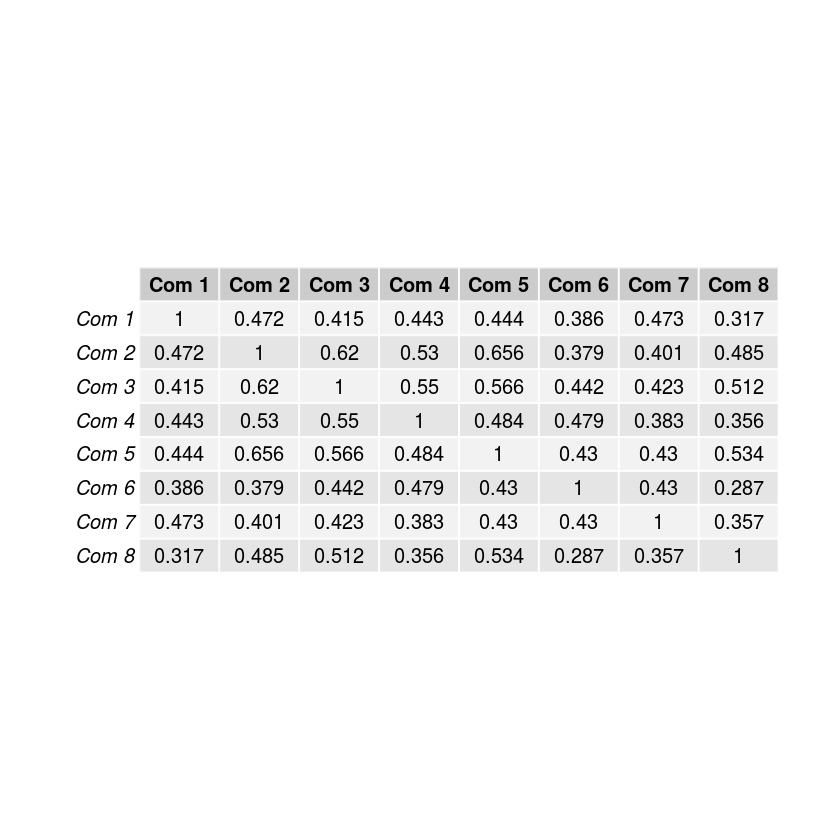

In [35]:
rownames(mclusterSim) <- names
colnames(mclusterSim) <- names
grid.table(mclusterSim[1:8, 1:8])

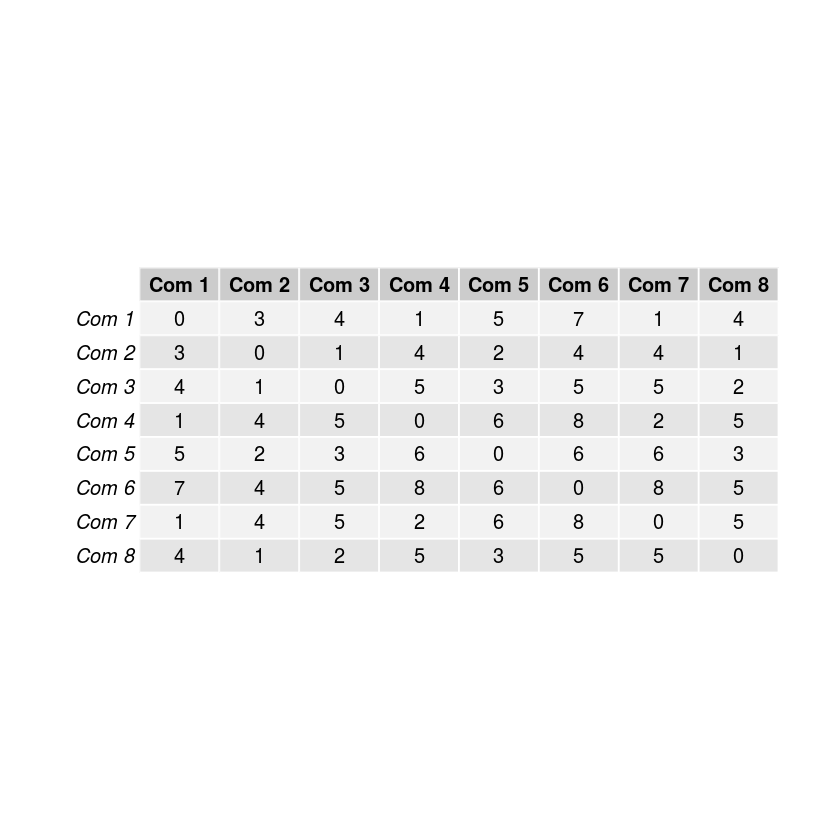

In [34]:
rownames(shortest.path) <- names
colnames(shortest.path) <- names
grid.table(shortest.path[1:8, 1:8])

In [ ]:
library(gri)

In [11]:
pathways <- read.table("../biochemical_pathways.tab", sep="\t")
cols <- c("pathway_name", "enzyme_name", "E.C._reaction_number", "gene_name", "reference")
colnames(pathways) <- cols

toGene <- function(ORFIdentifiers){
    genes <- character()
    for (identifier in ORFIdentifiers){
        gene <- character()
        try(
            gene <- as.character(org.Sc.sgdGENENAME[identifier])
        )
        genes <- c(genes, gene)
    }
    return(genes)
}

toPath <- function(ORFIdentifiers){
    paths <- character()
    for (identifier in ORFIdentifiers){
        path <- character()
        try(
            path <- as.character(org.Sc.sgdPATH[identifier])
        )
        paths <- c(paths, path)
    }
    return(paths)
}

get_pathways <- function(ORFIdentifiers, pathways) {
    genes  <- toGene(ORFIdentifiers)
    return(subset(pathways, gene_name %in% genes)$pathway_name)
}

get_pathway_genes <- function(ORFIdentifiers, pathways) {
    genes  <- toGene(ORFIdentifiers)
    return(subset(pathways, gene_name %in% genes)$gene_name)
}

In [12]:
pathway_list <- sapply(g, get_pathways, pathways)
pathway_genes <- sapply(g, get_pathway_genes, pathways)

In [15]:
enrichedGOsPathway <- sapply(pathway_genes[lengths(pathway_genes) > 0], enrichedGOTerms, allGenes=allGenes, 
                      cutoff=0.05, correction=FALSE, ont=ont, mapping=mapping, ID=ID)

ERROR: Error in .local(.Object, ...): allGenes must be a factor with 2 levels


In [ ]:
range <- 1:length(enrichedGOsPathway)

simsPathway <- sapply(range, function(i) sapply(range, function(j) 
                    mgoSim(names(enrichedGOsPathway[[i]]),
                        names(enrichedGOsPathway[[j]]),
                        semData=scGO, measure="Wang", combine="BMA")))

In [ ]:
head(simsPathway)

In [ ]:
head(shortest.path)

In [ ]:
geneSimilarities <- sapply(allGenes, function(i) 
    sapply(allGenes, function(j) 
        geneSim(i, j, semData=scGO, measure = "Wang", combine="BMA")))

In [ ]:
geneSimilarities

In [6]:
cutOff <- 0.05

filename <- sprintf("%s-%s-%s-%s.rda", file, p, cutOff, ont)

if (file.exists(filename)){
    
    print(sprintf("loading: %s", filename))
    load(filename)
    print("loaded")
    
} else {
    
    print("creating topGO objects")

    geneLists <- vector("list", numCom) 
    GOdataObjects <- vector("list", numCom) 
    resultFishers <- vector("list", numCom) 
    results <- vector("list", numCom) 
    gos <- vector("list", numCom) 

    #perform enrichment analyses
    for (c in 1:numCom){

        #factor of interesting genes
        geneList <- factor(as.integer(allGenes %in% g[[c]]))
        names(geneList) <- allGenes
        geneLists[[c]] <- geneList

        #construct topGO object
        GOdata <- new("topGOdata", description=sprintf("topGO object for community %s", c),
                      ontology = ont, allGenes = geneList,
                      annotationFun = annFUN.org, mapping = mapping, 
                      ID = ID, nodeSize = 10)
        GOdataObjects[[c]] <- GOdata

        #fishers exact test classic
        resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
        resultFishers[[c]] <- resultFisher

        #tabulate results
        allRes <- GenTable(GOdata, classicFisher = resultFisher,
                      orderBy = "classicFisher")
        results[[c]] <- allRes
        
        #go terms < cut off  Benjamini-Hochberg multiple hypothesis corrected pval
        gos[[c]] <- score(resultFisher)[which(p.adjust(score(resultFisher), method="BH") <= cutOff)]

        print(sprintf("community %s complete", c))
    }
    
    print(sprintf("Saving data: %s", filename))
    save(geneLists, GOdataObjects, resultFishers, results, gos, file=filename)
    print("saved")
}

[1] "creating topGO objects"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 355 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 1 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 581 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 2 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 835 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 3 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 681 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 4 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 586 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 5 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 644 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 6 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 877 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 7 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 706 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 8 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 831 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 9 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 408 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 10 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 516 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 11 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 567 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 12 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 706 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 13 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 531 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 14 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 473 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 15 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 612 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 16 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 577 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 17 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 501 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 18 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 463 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 19 complete"



Building most specific GOs .....
	( 1689 GO terms found. )

Build GO DAG topology ..........
	( 3643 GO terms and 8240 relations. )

Annotating nodes ...............
	( 1558 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 602 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 20 complete"
[1] "Saving data: yeast_union-0.7-0.05-BP.rda"
[1] "saved"


In [7]:
print_accession_number <- function(terms, file){
    for (s in strsplit(names(terms), ":")){
        write(s[2], file=file, append=TRUE)
    }
}

In [8]:
###write accession number to file
for (i in 1:length(gos)){
    accessionFile <- sprintf("accession_numbers-%s-%s-%s", cutOff, ont, i)
    print_accession_number(gos[[i]], file=accessionFile)
}

In [10]:
wangAllGeneSim <- mgeneSim(allGenes, semData=scGO, measure="Wang", combine="BMA", verbose=TRUE)

  |======================================================================| 100%


In [11]:
clusters <- hclust(as.dist(-log(wangAllGeneSim)))
clusterCut <- cutree(clusters, numCom)

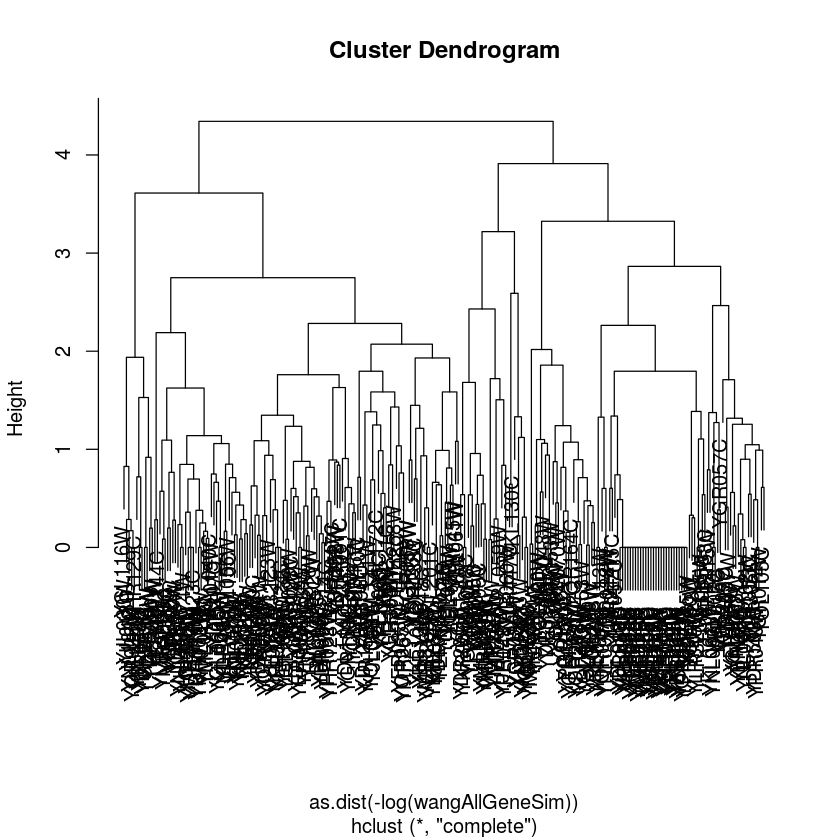

In [12]:
plot(clusters)

In [13]:
assignedCommunities <- numeric(length(allGenes))
names(assignedCommunities) <- allGenes

for (i in 1:numCom){
    for (geneName in g[[i]]){
        assignedCommunities[geneName] <- i
    }
}

In [14]:
library(NMI)

In [15]:
assignedCommunities <- assignedCommunities[names(assignedCommunities) %in% names(clusterCut)]

In [16]:
assignedCommunitiesDF <- data.frame(assignedCommunities)
assignedCommunitiesDF <- cbind(Row.Names = rownames(assignedCommunitiesDF), assignedCommunitiesDF)

In [17]:
clusterCutDF <- data.frame(clusterCut)
clusterCutDF <- cbind(Row.Names = rownames(clusterCutDF), clusterCutDF)

In [18]:
NMI(assignedCommunitiesDF, clusterCutDF)

$value
[1] 0.07110745

In [98]:
most_representative_term_weighted <- function(namedTerms){
    
    counts <- numeric(length(namedTerms))
    names(counts) <- names(namedTerms)

    for (term in names(namedTerms)) {
        ancestors <- as.list(GOBPANCESTOR[term])
        for (ancestor in ancestors[[term]]) {
            if (ancestor %in% names(counts)) {
                counts[ancestor] <- counts[ancestor] + 1
            }
        }

    }
#     return (sort(counts / sum(counts), decreasing=TRUE))
    return (sort(counts / max(counts), decreasing=TRUE))
}

In [33]:
most_representative_term_ancestor <- function(namedTerms){
    
    counts <- numeric(length(namedTerms))
    names(counts) <- names(namedTerms)

    for (term in names(namedTerms)) {
        ancestors <- as.list(GOBPANCESTOR[term])
        for (ancestor in ancestors[[term]]) {
            if (ancestor %in% names(counts)) {
                counts[ancestor] <- counts[ancestor] + 1
            }
        }

    }
#     return (sort(counts / sum(counts), decreasing=TRUE))
    return (names(sort(counts / sum(counts), decreasing=TRUE)[1]))
}

In [34]:
representativeTermsAncestor <- sapply(Filter(length, gos), most_representative_term_ancestor)

In [35]:
select(GO.db, keys=representativeTermsAncestor, columns=c("TERM", "DEFINITION"))

'select()' returned many:1 mapping between keys and columns


GOID,TERM,DEFINITION
GO:0006644,phospholipid metabolic process,"The chemical reactions and pathways involving phospholipids, any lipid containing phosphoric acid as a mono- or diester."
GO:0007049,cell cycle,"The progression of biochemical and morphological phases and events that occur in a cell during successive cell replication or nuclear replication events. Canonically, the cell cycle comprises the replication and segregation of genetic material followed by the division of the cell, but in endocycles or syncytial cells nuclear replication or nuclear division may not be followed by cell division."
GO:0044699,single-organism process,A biological process that involves only one organism.
GO:0044710,single-organism metabolic process,"A metabolic process - chemical reactions and pathways, including anabolism and catabolism, by which living organisms transform chemical substances - which involves a single organism."
GO:0051128,regulation of cellular component organization,"Any process that modulates the frequency, rate or extent of a process involved in the formation, arrangement of constituent parts, or disassembly of cell structures, including the plasma membrane and any external encapsulating structures such as the cell wall and cell envelope."
GO:0034641,cellular nitrogen compound metabolic process,"The chemical reactions and pathways involving various organic and inorganic nitrogenous compounds, as carried out by individual cells."
GO:0006725,cellular aromatic compound metabolic process,"The chemical reactions and pathways involving aromatic compounds, any organic compound characterized by one or more planar rings, each of which contains conjugated double bonds and delocalized pi electrons, as carried out by individual cells."
GO:0044710,single-organism metabolic process,"A metabolic process - chemical reactions and pathways, including anabolism and catabolism, by which living organisms transform chemical substances - which involves a single organism."
GO:0044238,primary metabolic process,"The chemical reactions and pathways involving those compounds which are formed as a part of the normal anabolic and catabolic processes. These processes take place in most, if not all, cells of the organism."
GO:0044699,single-organism process,A biological process that involves only one organism.


In [36]:
simsGOAncestor <- mgoSim(representativeTermsAncestor, representativeTermsAncestor, semData=scGO, measure="Wang", combine=NULL)

In [37]:
head(simsGOAncestor)

,GO:0006644,GO:0007049,GO:0044699,GO:0044710,GO:0051128,GO:0034641,GO:0006725,GO:0044238,GO:0005975,GO:0030029,⋯,GO:0071840,GO:0043603,GO:0009132,GO:0009058,GO:0048519,GO:1901360,GO:0022402,GO:0007163,GO:0043170,GO:0016043
GO:0006644,1.000,0.354,0.239,0.405,0.130,0.334,0.354,0.323,0.362,0.354,⋯,0.106,0.294,0.618,0.197,0.087,0.281,0.339,0.354,0.281,0.184
GO:0007049,0.354,1.000,0.547,0.379,0.245,0.289,0.321,0.191,0.139,0.722,⋯,0.243,0.256,0.291,0.191,0.180,0.156,0.872,0.722,0.156,0.379
GO:0044699,0.239,0.547,1.000,0.643,0.178,0.212,0.243,0.340,0.236,0.547,⋯,0.444,0.192,0.198,0.340,0.304,0.276,0.493,0.547,0.276,0.286
GO:0044710,0.405,0.379,0.643,1.000,0.129,0.340,0.379,0.507,0.371,0.379,⋯,0.286,0.305,0.336,0.507,0.210,0.419,0.349,0.379,0.419,0.198
GO:0051128,0.130,0.245,0.178,0.129,1.000,0.225,0.245,0.142,0.107,0.245,⋯,0.400,0.198,0.107,0.142,0.447,0.117,0.229,0.245,0.117,0.651
GO:0034641,0.334,0.289,0.212,0.340,0.225,1.000,0.649,0.379,0.283,0.289,⋯,0.212,0.888,0.433,0.379,0.161,0.314,0.268,0.289,0.314,0.340


In [38]:
head(shortest.path)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52
0,1,1,1,1,2,2,1,2,2,⋯,5,3,5,2,4,3,3,3,3,3
1,0,1,1,1,1,2,2,1,2,⋯,5,3,5,2,4,3,3,3,2,2
1,1,0,2,2,2,3,2,2,3,⋯,6,2,6,3,5,4,2,2,3,3
1,1,2,0,2,2,3,2,2,3,⋯,6,4,6,3,5,4,4,4,3,3
1,1,2,2,0,1,1,1,1,1,⋯,4,4,4,1,3,2,4,4,2,2
2,1,2,2,1,0,1,2,2,2,⋯,5,4,5,2,4,3,4,4,1,1


In [15]:
information_content <- function(term){
    return (goSim(term, term, semData=scGO, measure="Resnik"))
}

most_representative_term_ic <- function(namedTerms){
    ics <- sapply(names(namedTerms), information_content)
    names(ics) <- names(namedTerms)
    return(names(sort(ics, decreasing=TRUE)[1]))
}

In [16]:
representativeTermsIC <- sapply(Filter(length, gos), most_representative_term_ic)

In [17]:
select(GO.db, keys=representativeTermsIC, columns=c("TERM", "DEFINITION"))

'select()' returned 1:1 mapping between keys and columns


GOID,TERM,DEFINITION
GO:0090114,COPII-coated vesicle budding,"The evagination of an endoplasmic reticulum membrane, resulting in formation of a COPII-coated vesicle."
GO:0031146,SCF-dependent proteasomal ubiquitin-dependent protein catabolic process,"The chemical reactions and pathways resulting in the breakdown of a protein or peptide by hydrolysis of its peptide bonds, initiated by the covalent attachment of ubiquitin, with ubiquitin-protein ligation catalyzed by an SCF (Skp1/Cul1/F-box protein) complex, and mediated by the proteasome."
GO:0009132,nucleoside diphosphate metabolic process,"The chemical reactions and pathways involving a nucleoside diphosphate, a compound consisting of a nucleobase linked to a deoxyribose or ribose sugar esterified with diphosphate on the sugar."
GO:0044038,cell wall macromolecule biosynthetic process,The chemical reactions and pathways resulting in the formation of a macromolecule destined to form part of a cell wall.
GO:0043467,regulation of generation of precursor metabolites and energy,"Any process that modulates the frequency, rate or extent of the chemical reactions and pathways resulting in the formation of precursor metabolites, substances from which energy is derived, and the processes involved in the liberation of energy from these substances."
GO:0008033,tRNA processing,"The process in which a pre-tRNA molecule is converted to a mature tRNA, ready for addition of an aminoacyl group."
GO:0031113,regulation of microtubule polymerization,"Any process that modulates the frequency, rate or extent of microtubule polymerization."
GO:0051123,RNA polymerase II transcriptional preinitiation complex assembly,"The aggregation, arrangement and bonding together of proteins on an RNA polymerase II promoter DNA to form the transcriptional preinitiation complex (PIC), the formation of which is a prerequisite for transcription by RNA polymerase."
GO:0006896,Golgi to vacuole transport,The directed movement of substances from the Golgi to the vacuole.
GO:0016973,poly(A)+ mRNA export from nucleus,The directed movement of poly(A)+ mRNA out of the nucleus into the cytoplasm.


In [18]:
simsGOIC <- mgoSim(representativeTermsIC, representativeTermsIC, semData=scGO, measure="Wang", combine=NULL)

In [19]:
head(simsGOIC)

,GO:0090114,GO:0031146,GO:0009132,GO:0044038,GO:0043467,GO:0008033,GO:0031113,GO:0051123,GO:0006896,GO:0016973,GO:0006576,GO:0002181,GO:0040001,GO:0016558,GO:0006999,GO:0007096,GO:1904669
GO:0090114,1.000,0.045,0.126,0.083,0.070,0.050,0.187,0.086,0.551,0.392,0.068,0.048,0.428,0.496,0.197,0.193,0.214
GO:0031146,0.045,1.000,0.186,0.241,0.161,0.226,0.037,0.154,0.024,0.092,0.196,0.296,0.040,0.032,0.072,0.035,0.020
GO:0009132,0.126,0.186,1.000,0.193,0.192,0.404,0.102,0.294,0.065,0.112,0.350,0.247,0.119,0.097,0.089,0.106,0.056
GO:0044038,0.083,0.241,0.193,1.000,0.205,0.270,0.106,0.399,0.029,0.114,0.250,0.462,0.080,0.064,0.141,0.071,0.025
GO:0043467,0.070,0.161,0.192,0.205,1.000,0.185,0.181,0.126,0.039,0.063,0.274,0.162,0.068,0.053,0.128,0.176,0.033
GO:0008033,0.050,0.226,0.404,0.270,0.185,1.000,0.042,0.383,0.026,0.130,0.328,0.328,0.046,0.037,0.083,0.040,0.021


In [20]:
head(shortest.path)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
0,1,1,1,1,1,2,1,2,2,2,2,3,3,2,3,2,3,3,4
1,0,1,1,2,2,1,1,1,1,1,1,2,2,1,2,1,2,2,3
1,1,0,2,2,1,1,2,2,2,2,2,3,3,2,2,2,3,3,4
1,1,2,0,1,2,2,2,2,2,2,2,3,3,2,3,2,3,3,4
1,2,2,1,0,2,3,2,3,3,3,3,4,4,3,4,3,4,4,5
1,2,1,2,2,0,2,2,3,3,3,3,4,4,3,3,3,4,4,5


In [148]:
wangClusterSim <- mclusterSim(g, semData=scGO, measure="Wang", combine="BMA")

In [149]:
head(wangClusterSim)

1.000,0.527,0.544,0.491,0.534,0.491,0.513,0.495,0.448,0.505,0.375,0.632,0.531
0.527,1.000,0.610,0.568,0.520,0.534,0.523,0.507,0.548,0.540,0.455,0.584,0.494
0.544,0.610,1.000,0.625,0.523,0.608,0.651,0.606,0.634,0.602,0.358,0.604,0.391
0.491,0.568,0.625,1.000,0.514,0.558,0.609,0.552,0.623,0.592,0.416,0.521,0.383
0.534,0.520,0.523,0.514,1.000,0.496,0.514,0.522,0.464,0.585,0.409,0.554,0.453
0.491,0.534,0.608,0.558,0.496,1.000,0.557,0.540,0.539,0.549,0.354,0.591,0.453


In [150]:
head(shortest.path)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
0,1,1,1,2,2,1,1,2,2,1,1,1
1,0,1,2,1,1,2,2,3,1,2,2,2
1,1,0,1,1,2,2,2,3,2,2,2,2
1,2,1,0,2,3,1,2,2,3,2,2,2
2,1,1,2,0,1,3,3,4,2,3,3,3
2,1,2,3,1,0,3,3,4,1,3,3,3


In [156]:
goSims <- matrix(numeric(), nrow=numCom, ncol=numCom)

for (i in 1:numCom){
    for (j in 1:numCom){
        goSims[i, j] = mgoSim(names(gos[[i]]), names(gos[[j]]), measure="Wang", semData=scGO, combine="BMA")
    }
}

In [157]:
head(goSims)

1.000,0.164,0.093,0.140,0.602,0.145,0.221,0.338,0.134,0.276,NA,0.525,0.626
0.164,1.000,0.633,0.475,0.171,0.348,0.363,0.322,0.672,0.234,NA,0.362,0.082
0.093,0.633,1.000,0.343,0.085,0.286,0.411,0.201,0.563,0.200,NA,0.246,0.073
0.140,0.475,0.343,1.000,0.132,0.321,0.236,0.226,1.000,0.276,NA,0.331,0.094
0.602,0.171,0.085,0.132,1.000,0.182,0.298,0.511,0.134,0.234,NA,0.447,0.537
0.145,0.348,0.286,0.321,0.182,1.000,0.285,0.278,0.385,0.286,NA,0.368,0.137


In [18]:
wangGoSims <- sapply(names(enrichedGOs), 
                     function(i) sapply(names(enrichedGOs), 
                                        function(j) mgoSim(i, j, semData=scGO, measure="Wang", combine="BMA")))

In [19]:
wangGoSims

list()

In [22]:
mgeneSim(allGeneNames[as.integer(g[[1]])], semData=scGO, measure="Wang", combine="BMA")

  |======================================================================| 100%


,YML028W,YGL122C,YPL214C,YHL006C,YKL130C,YCR011C,YBL007C,YJR091C,YGL145W,YBR133C,YDR214W,YGR268C,YLR291C,YOR138C,YEL023C,YFR002W
YML028W,1.000,0.218,0.330,0.389,0.193,0.385,0.183,0.150,0.121,0.324,0.547,0.477,0.146,0.157,0.477,0.152
YGL122C,0.218,1.000,0.270,0.318,0.119,0.340,0.085,0.332,0.451,0.351,0.098,0.185,0.295,0.223,0.185,0.326
YPL214C,0.330,0.270,1.000,0.338,0.188,0.171,0.131,0.212,0.053,0.319,0.106,0.069,0.396,0.123,0.069,0.080
YHL006C,0.389,0.318,0.338,1.000,0.208,0.234,0.264,0.263,0.078,0.310,0.235,0.105,0.230,0.249,0.105,0.196
YKL130C,0.193,0.119,0.188,0.208,1.000,0.245,0.176,0.298,0.203,0.152,0.142,0.243,0.118,0.091,0.243,0.156
YCR011C,0.385,0.340,0.171,0.234,0.245,1.000,0.391,0.242,0.512,0.373,0.284,0.196,0.161,0.112,0.196,0.350
YBL007C,0.183,0.085,0.131,0.264,0.176,0.391,1.000,0.149,0.453,0.167,0.158,0.283,0.079,0.062,0.283,0.328
YJR091C,0.150,0.332,0.212,0.263,0.298,0.242,0.149,1.000,0.344,0.210,0.118,0.200,0.115,0.140,0.200,0.221
YGL145W,0.121,0.451,0.053,0.078,0.203,0.512,0.453,0.344,1.000,0.117,0.095,0.158,0.045,0.035,0.158,0.451
YBR133C,0.324,0.351,0.319,0.310,0.152,0.373,0.167,0.210,0.117,1.000,0.192,0.217,0.294,0.330,0.217,0.132


In [21]:
mgoSim(names(enrichedGOs[[1]]), names(enrichedGOs[[2]]), semData=scGO, measure="Wang", combine="BMA")

[1] 0.106

In [15]:
head(shortest.path)

V1,V2,V3,V4,V5,V6
0,1,1,1,1,1
1,0,1,2,2,2
1,1,0,1,1,1
1,2,1,0,2,2
1,2,1,2,0,2
1,2,1,2,2,0


In [116]:
distances <- numeric(length = (numCom * (numCom - 1)) / 2)
semSims <- numeric(length = (numCom * (numCom - 1)) / 2)

completed <- 0

for (c1 in 1:length(enrichedGOsPathway)) {
    
    for (c2 in c1:length(enrichedGOsPathway)) {
        
        if (c1 == c2) next   
        
        completed <- completed + 1  
        semSims[completed] <- simsPathway[c1, c2]
            
        distances[completed] <- shortest.path[c1, c2]
        
        print(sprintf("Completed: %s", completed))
    }
}

[1] "Completed: 1"
[1] "Completed: 2"
[1] "Completed: 3"
[1] "Completed: 4"
[1] "Completed: 5"
[1] "Completed: 6"
[1] "Completed: 7"
[1] "Completed: 8"
[1] "Completed: 9"
[1] "Completed: 10"
[1] "Completed: 11"
[1] "Completed: 12"
[1] "Completed: 13"
[1] "Completed: 14"
[1] "Completed: 15"
[1] "Completed: 16"
[1] "Completed: 17"
[1] "Completed: 18"
[1] "Completed: 19"
[1] "Completed: 20"
[1] "Completed: 21"
[1] "Completed: 22"
[1] "Completed: 23"
[1] "Completed: 24"
[1] "Completed: 25"
[1] "Completed: 26"
[1] "Completed: 27"
[1] "Completed: 28"
[1] "Completed: 29"
[1] "Completed: 30"
[1] "Completed: 31"
[1] "Completed: 32"
[1] "Completed: 33"
[1] "Completed: 34"
[1] "Completed: 35"
[1] "Completed: 36"
[1] "Completed: 37"
[1] "Completed: 38"
[1] "Completed: 39"
[1] "Completed: 40"
[1] "Completed: 41"
[1] "Completed: 42"
[1] "Completed: 43"
[1] "Completed: 44"
[1] "Completed: 45"
[1] "Completed: 46"
[1] "Completed: 47"
[1] "Completed: 48"
[1] "Completed: 49"
[1] "Completed: 50"
[1] "Comp

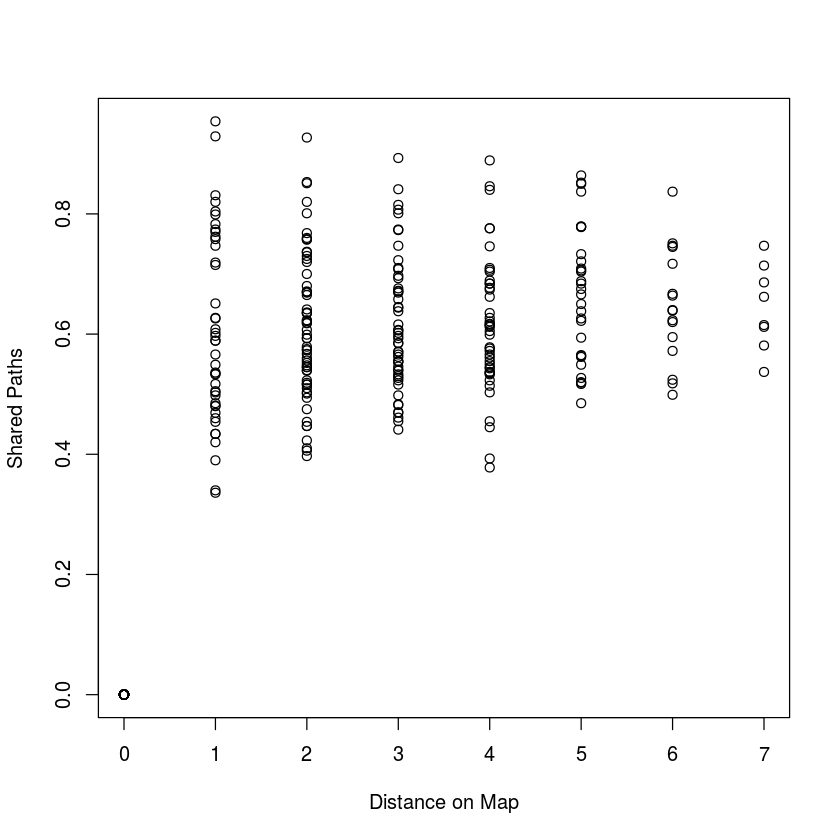

In [117]:
plot(distances, semSims, xlab="Distance on Map", ylab="Shared Paths")

In [102]:
cor(distances, semSims, method="spearman")

[1] -0.05678169

In [42]:
library(GOSim)
setOntology(ont, loadIC=FALSE)
setEvidenceLevel(evidences="all",organism=org.Sc.sgdORGANISM, gomap=org.Sc.sgdGO)
e <- GOenrichment(g[[46]], allGenes)

-> retrieving GO information for all available genes for organism 'Saccharomyces cerevisiae' in GO database
-> filtering GO terms according to evidence levels 'all'

Building most specific GOs .....
	( 1690 GO terms found. )

Build GO DAG topology ..........
	( 3645 GO terms and 8243 relations. )

Annotating nodes ...............
	( 1567 genes annotated to the GO terms. )

			 -- Elim Algorithm -- 

		 the algorithm is scoring 172 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 14:	1 nodes to be scored	(0 eliminated genes)

	 Level 13:	3 nodes to be scored	(0 eliminated genes)

	 Level 12:	7 nodes to be scored	(0 eliminated genes)

	 Level 11:	9 nodes to be scored	(0 eliminated genes)

	 Level 10:	8 nodes to be scored	(1 eliminated genes)

	 Level 9:	17 nodes to be scored	(3 eliminated genes)

	 Level 8:	14 nodes to be scored	(8 eliminated genes)

	 Level 7:	20 nodes to be scored	(8 eliminated genes)

	 Level 6:	25 nodes to be scored	(8 eliminated 

In [49]:
e

,go_id,Term,Definition
15591,GO:0018343,protein farnesylation,The covalent attachment of a farnesyl group to a protein.
15594,GO:0018344,protein geranylgeranylation,The covalent attachment of a geranylgeranyl group to a protein.
16626,GO:0006874,cellular calcium ion homeostasis,Any process involved in the maintenance of an internal steady state of calcium ions at the level of a cell.
17047,GO:0030010,establishment of cell polarity,The specification and formation of anisotropic intracellular organization or cell growth patterns.
48636,GO:0042127,regulation of cell proliferation,"Any process that modulates the frequency, rate or extent of cell proliferation."
79331,GO:0070884,regulation of calcineurin-NFAT signaling cascade,"Any process that modulates the frequency, rate or extent of the calcineurin-NFAT signaling cascade."


In [88]:
goTerms <- e$GOTerms
p.values <- e$p.values

In [89]:
p.values.df <- data.frame(p.values)
p.values.df["go_id"] <- names(p.values)
p.values.df

,p.values,go_id
GO:0006874,8.917154e-03,GO:0006874
GO:0042127,4.467135e-03,GO:0042127
GO:0070884,4.467135e-03,GO:0070884
GO:0018343,1.711546e-05,GO:0018343
GO:0018344,1.700630e-04,GO:0018344
GO:0030010,3.451281e-03,GO:0030010


In [90]:
goTerms <- merge(goTerms, p.values.df, by="go_id")

In [93]:
colnames(goTerms) <- c("GO_ID", "TERM", "DEFINITION", "P_VALUE")
head(goTerms)

GO_ID,TERM,DEFINITION,P_VALUE
GO:0006874,cellular calcium ion homeostasis,Any process involved in the maintenance of an internal steady state of calcium ions at the level of a cell.,8.917154e-03
GO:0018343,protein farnesylation,The covalent attachment of a farnesyl group to a protein.,1.711546e-05
GO:0018344,protein geranylgeranylation,The covalent attachment of a geranylgeranyl group to a protein.,1.700630e-04
GO:0030010,establishment of cell polarity,The specification and formation of anisotropic intracellular organization or cell growth patterns.,3.451281e-03
GO:0042127,regulation of cell proliferation,"Any process that modulates the frequency, rate or extent of cell proliferation.",4.467135e-03
GO:0070884,regulation of calcineurin-NFAT signaling cascade,"Any process that modulates the frequency, rate or extent of the calcineurin-NFAT signaling cascade.",4.467135e-03


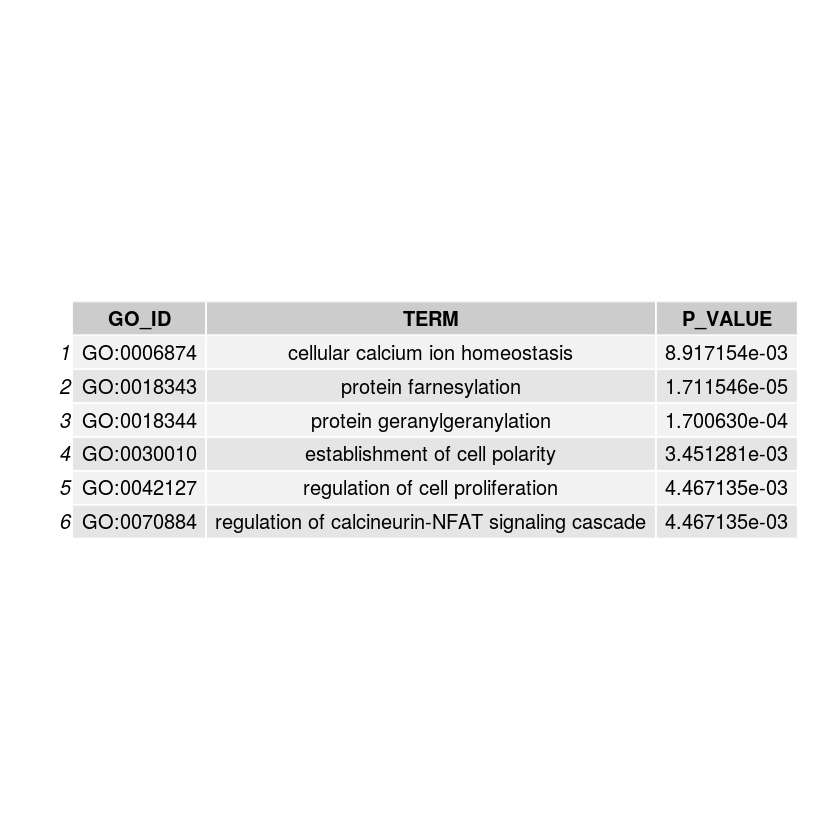

In [94]:
library(gridExtra)
grid.table(goTerms[,c("GO_ID", "TERM", "P_VALUE")])

In [46]:
g[[46]]

[1] "YKL019W" "YGL155W" "YKL159C" "YCR063W" "YBR247C" "YDL090C" "YOL135C"

In [103]:
l <- as.list(org.Sc.sgdGO[["YKL019W"]])

In [116]:
gos <- sapply(l, function(i) i[["GOID"]])

In [122]:
t <- select(GO.db, keys=gos, columns=c("GOID","TERM","ONTOLOGY"))

'select()' returned many:1 mapping between keys and columns


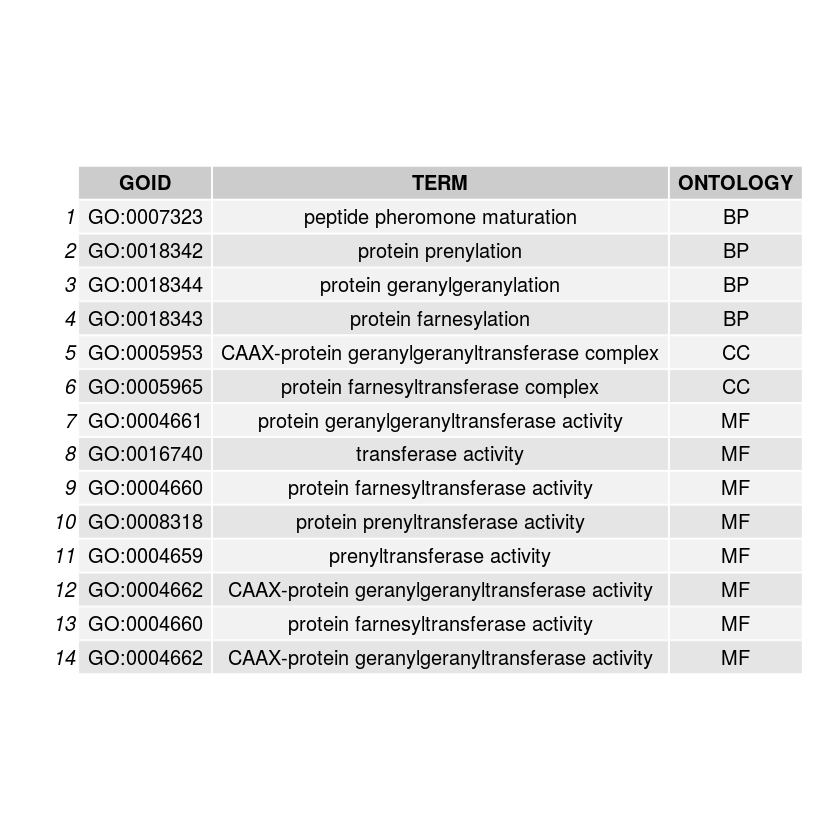

In [123]:
grid.table(t)